In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
FOLDER_PATH = "D:\\Google Drive\\Catherning Folder\\THU\\Thesis\\Recipe datasets\\scirep-cuisines-detail"
FILES = ["allr_recipes.txt","epic_recipes.txt","menu_recipes.txt"]

In [25]:
recipes = []
for file in FILES:
    with open(os.path.join(FOLDER_PATH,file)) as f:
        for i,recipe in enumerate(f):
            data = recipe.strip('\n').split('\t')
            recipes.append({"cuisine":data[0],"id":i,"ingredients":data[1:]})
        
df_train = pd.DataFrame(recipes)
df_train

,cuisine,id,ingredients
0,Canada,0,"[egg, yeast, wheat, milk, lard]"
1,Canada,1,"[pork, carrot, pea, onion, potato]"
2,Canada,2,[maple_syrup]
3,Canada,3,"[wheat, yeast, almond, honey, oat, date, veget..."
4,Canada,4,"[butter, lovage, clam, wheat, onion, thyme, po..."
...,...,...,...
57686,italian,2453,"[kiwi, olive_oil, clam, white_wine, orange, sa..."
57687,italian,2454,"[tomato, butter, beef, onion, red_wine, black_..."
57688,italian,2455,"[vegetable, wheat, egg, cheese, olive_oil]"
57689,italian,2456,"[tomato, clam, black_pepper, parsley, celery, ..."


American        40150
Mexico           1754
Italian          1715
Italy            1461
Asian            1176
                ...  
Indonesia          12
East-African       11
Belgium            11
Israel              9
Bangladesh          4
Name: cuisine, Length: 69, dtype: int64

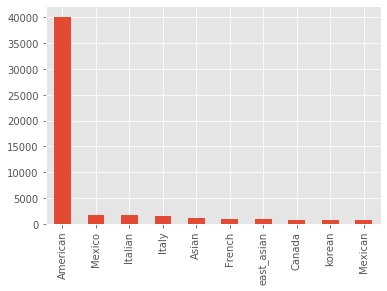

In [36]:
%matplotlib inline

plt.style.use('ggplot')
df_train['cuisine'].value_counts().head(10).plot(kind='bar')

df_train['cuisine'].value_counts()

In [28]:
counters = {}
for cuisine in df_train['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (df_train['cuisine'] == cuisine)
    for ingredients in df_train[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [29]:
counters['italian'].most_common(10)

[('black_pepper', 54),
 ('olive_oil', 40),
 ('onion', 37),
 ('garlic', 32),
 ('macaroni', 30),
 ('tomato', 29),
 ('wheat', 28),
 ('butter', 27),
 ('white_wine', 21),
 ('basil', 20)]

In [37]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
Canada,wheat,butter,egg,onion,garlic,milk,black_pepper,cane_molasses,vegetable_oil,pepper
Turkey,garlic,onion,tomato,butter,wheat,yogurt,olive_oil,bell_pepper,pepper,egg
Caribbean,onion,garlic,vegetable_oil,black_pepper,tomato,olive_oil,pepper,cayenne,bell_pepper,chicken
Bangladesh,onion,cayenne,vegetable_oil,turmeric,garlic,cilantro,coriander,beef,potato,cardamom
India,cumin,onion,turmeric,garlic,cayenne,coriander,ginger,vegetable_oil,pepper,tomato
...,...,...,...,...,...,...,...,...,...,...
east_asian,garlic,soy_sauce,scallion,cayenne,sesame_oil,black_pepper,rice,ginger,vegetable_oil,soybean
asian,rice,black_pepper,coriander,cayenne,onion,garlic,vegetable,fish,cucumber,shrimp
western,egg,wheat,butter,black_pepper,onion,milk,vegetable_oil,tomato,garlic,vinegar
korean,garlic,scallion,cayenne,soy_sauce,sesame_oil,black_pepper,rice,soybean,roasted_sesame_seed,vegetable


In [39]:
df_train['all_ingredients'] = df_train['ingredients'].map(";".join)

df_train.head()



,cuisine,id,ingredients,all_ingredients
0,Canada,0,"[egg, yeast, wheat, milk, lard]",egg;yeast;wheat;milk;lard
1,Canada,1,"[pork, carrot, pea, onion, potato]",pork;carrot;pea;onion;potato
2,Canada,2,[maple_syrup],maple_syrup
3,Canada,3,"[wheat, yeast, almond, honey, oat, date, veget...",wheat;yeast;almond;honey;oat;date;vegetable_oi...
4,Canada,4,"[butter, lovage, clam, wheat, onion, thyme, po...",butter;lovage;clam;wheat;onion;thyme;potato;ye...


In [57]:
df_train['all_ingredients'].str.contains('garlic').value_counts()

False    40226
True     17465
Name: all_ingredients, dtype: int64

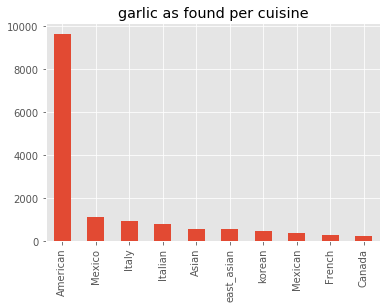

In [60]:
indices = df_train['all_ingredients'].str.contains('garlic')
df_train[indices]['cuisine'].value_counts().head(10).plot(kind='bar',
                                                 title='garlic as found per cuisine')

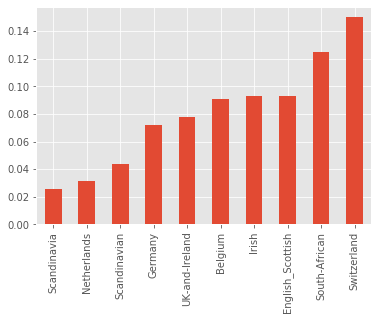

In [64]:
relative_freq = (df_train[indices]['cuisine'].value_counts() / df_train['cuisine'].value_counts())
relative_freq.sort_values(inplace=True)
relative_freq.head(10).plot(kind='bar')
